In [28]:
import soundfile as sf
import matplotlib.pyplot as plt
import sounddevice as sd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import find_peaks
from code_exercise1 import my_windowing, get_index_from_time, get_input_split_size, get_fundamental_frequency
from code_exercise2 import convert_to_samples, compute_stft, plot_spectrogram

threshold = 75
def load_audio(file_path: str) -> [np.ndarray, int]:
    """
    Load an audio file.

    :param file_path: path to the audio file
    :return: a tuple containing
        - the audio data
        - the sampling rate
    """
    return sf.read(file_path)
def compute_power(signal_segment: np.ndarray) -> float:
    """
    Compute the power of a signal segment.

    :param signal_segment: the signal segment
    :return: the power of the signal segment
    """
    return np.sum(signal_segment**2)/len(signal_segment)

def compute_power_for_all_frames(m_frames: np.ndarray) -> np.ndarray:
    """
    Compute the power for all frames.

    :param m_frames: matrix containing the frames
    :return: a vector containing the power for all frames
    """
    return np.apply_along_axis(compute_power, 1, m_frames)

def count_zero_crossings(signal_segment: np.ndarray) -> np.ndarray:
    """
    Count the zero crossings in a signal segment.

    :param signal_segment: the signal segment
    :return: the number of zero crossings
    """
    return np.sum(np.where(signal_segment*np.roll(signal_segment, 1)<=0, 1, 0))

def is_voiced(signal_segments: np.ndarray) -> np.ndarray:
    """
    Check if a signal segment is voiced.

    :param signal_segment: the signal segment
    :return: 1 if the signal segment is voiced, 0 otherwise
    """

    return get_number_of_zero_crossings(signal_segments) < threshold

def get_number_of_zero_crossings(signal) -> np.ndarray:
    """
    Get the number of zero crossings for all frames.

    :param signal: the signal
    :return: a vector containing the number of zero crossings for all frames
    """
    return np.apply_along_axis(count_zero_crossings, 1, signal)

    


In [29]:
# 2.2.1
x, fs = load_audio('Audio/female8khz.wav')
N = 32
R = 8 #segment shift
L = N - R 
m_frames, v_time_frame = my_windowing(x, fs, N, R)
# Why do we segment the signal prior to analysis instead of processing the whole signal at once?
# -> more detailed: we want to detect the different vowels and consonants in the signal in time
# -> analyzing bigger segments needs more frequencies -> more data -> more computation time
# Is a segment length of 32 ms appropriate? Why or why not?
# -> convert_to_samples(32, fs) = 256 sampels 
# -> tradeoff between time resolution and frequency resolution


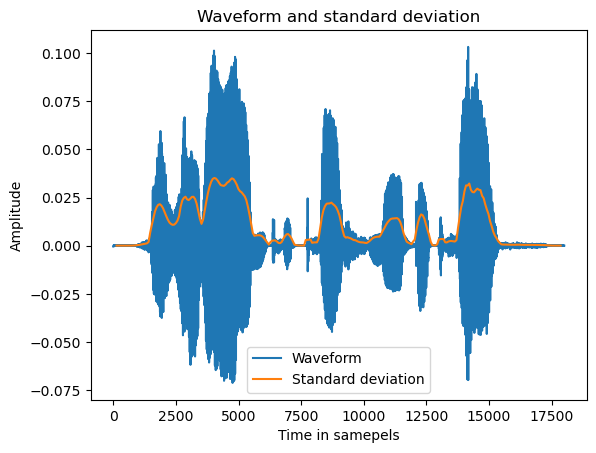

<Figure size 640x480 with 0 Axes>

In [30]:
# 2.2.2
# Compute the power of each frame
v_power = compute_power_for_all_frames(m_frames)
# standrad deviation
v_std = np.sqrt(v_power)
# plot waveform and v_std
plt.plot(x, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), v_std, label='Standard deviation')
plt.title('Waveform and standard deviation')
plt.xlabel('Time in samepels')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
plt.clf()

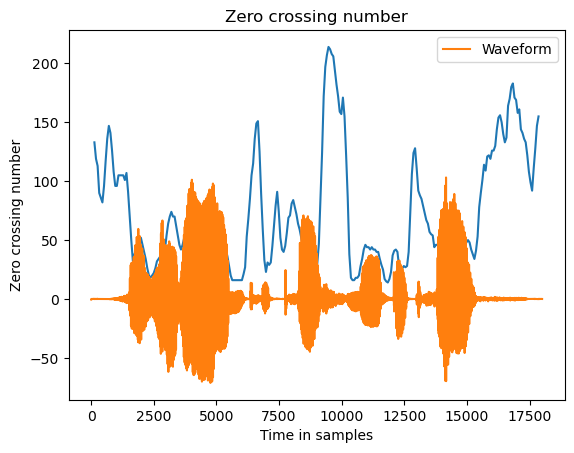

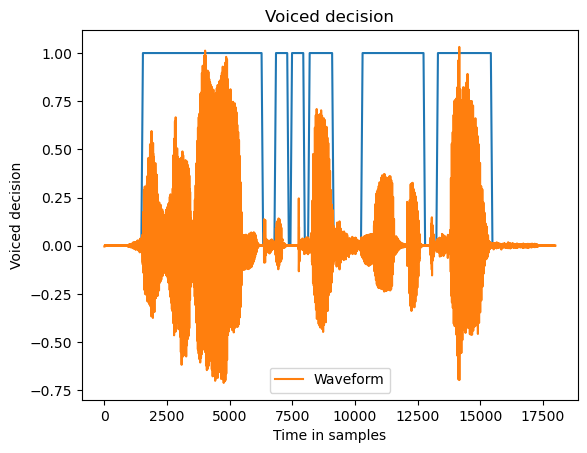

<Figure size 640x480 with 0 Axes>

In [31]:
# 2.2.3
# Explain differences in the creation of speech for voiced and unvoiced sounds.
# -> voiced sounds: vocal cords vibrate -> periodic signal, unvoiced sounds: turbulent airflow -> aperiodic signal aka noise (more zero crossings)
# Why might the number of zero crossings provide valuable information for the voiced/unvoiced decision?
# -> voiced sounds: less zero crossings, unvoiced sounds: more zero crossings
# Think of a way how you can efficiently detect a zero crossing between two samples. How can you realize that in Python?
# -> sample[i] * sample[i+1] < 0 oder ein schritt in der auto correlation: np.sum(np.sign(sample* sample.shift(1)))

zero_crossing_number = get_number_of_zero_crossings(m_frames)
plt.plot(get_index_from_time(v_time_frame/1000, fs), zero_crossing_number)
plt.plot(x*1000, label='Waveform')
plt.title('Zero crossing number')
plt.xlabel('Time in samples')
plt.ylabel('Zero crossing number')
plt.legend()
plt.show()
plt.clf()

# we threshold around 80 zero crossings

voiced_decision = is_voiced(m_frames)
plt.plot(get_index_from_time(v_time_frame/1000, fs), voiced_decision)
plt.plot(x*10, label='Waveform')
plt.title('Voiced decision')
plt.xlabel('Time in samples')
plt.ylabel('Voiced decision')
plt.legend()
plt.show()
plt.clf()

# In general: are all speech sounds either voiced or unvoiced? Can you think of other speech sounds? Examples?
# ->  deutsches R und v (rauschen und stimmhaft), 

In [35]:
# 2.4.

def estimate_f0(m_frames: np.ndarray, fs: int) -> np.ndarray:
    return np.apply_along_axis(get_fundamental_frequency, 1, x, fs, N, R)


freq_estimate = estimate_f0(m_frames, fs)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

plot_spectrogram(x, fs, N, R, ax=ax)

    
    

AxisError: axis 1 is out of bounds for array of dimension 1